# Network Analysis of Harry Potter Book Series

## Setup

In [20]:
# !pip install -r requirements.txt
!pip install matplotlib

  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)


## Function Definitions for Text Analysis

`happiness(doc)` takes a list of words and computes the average happiness score using the Hedonometer

`emotion_score(doc)` takes a list of words and computes a dictionary of average emotion scores among the emotions: _Anger, Anticipation,	Disgust, Fear, Joy, Sadness, Surprise_ and _Trust_

`vader_sentiment(doc)` takes a list of words and/or sentences and computes the average VADER compund score

`TF_IDF(docs_to_analyse, all_docs)` computes TF and TF-IDF score of terms in docs_to_analyse. all_docs are used to comput IDF scores 


In [5]:
import numpy as np
import pickle as pkl
import pandas as pd
import nltk
from clean_books import clean_book
from sentiment import *
import os, re
from difflib import SequenceMatcher
from tqdm.auto import tqdm

In [2]:
chapter_info = pd.read_pickle('data/chapter_dataframe.pkl')
#Add book number to chapters
idx = chapter_info.index[chapter_info["Local Chapter"] == 1]
for i in range(7):
    chapter_info.loc[idx[i]:(idx[i+1] if i+1 < len(idx) else None), "Book"] = int(i+1)
chapter_info

,Global Chapter,Local Chapter,Title,Approx Story Time,Book
0,1,1,The Boy Who Lived,1981-11-01,1.0
1,2,2,The Vanishing Glass,1991-06-23,1.0
2,3,3,The Letters from No One,1991-07-23,1.0
3,4,4,The Keeper of Keys,1991-07-31,1.0
4,5,5,Diagon Alley,1991-07-31,1.0
...,...,...,...,...,...
194,195,33,The Prince’s Tale,1998-05-02,7.0
195,196,34,The Forest Again,1998-05-02,7.0
196,197,35,King’s Cross,1998-05-02,7.0
197,198,36,The Flaw in the Plan,1998-05-02,7.0


In [3]:
with open('data/characters_by_house.pkl', 'rb') as file:
    characters_by_communities = pkl.load(file)

# characters_by_communities

In [440]:
# Get a list of paths to books
path = "data/books/"
books = os.listdir(path)
books.sort()
books_in_chapters = []

for i in tqdm(range(7), desc='Book Loop'): # For every book
    # Remove HTML TAGS and double spacing
    print("\n", file = sys.stderr)
    book = clean_book(path + books[i]) 
    book = re.sub('\n{2,}', '\n', book)
    # Get chapters of book
    chapters = [chapter.upper() for chapter in chapter_info.loc[chapter_info["Book"] == i+1, "Title"]]

    # Split Lines and remove lines including page numbering or J.K. Rowling
    lines[:] = [line for line in book.splitlines() if not re.search(r'Page \| [0-9]{1,} | J.K. Rowling', line)]        

    # Find lines with the title of the chapters
    chapter_idx = []
    for chapter in chapters:
        # Use SequenceMatcher to find similarity between line and a given chapter. Threshold of 0.6
        ties = [(i, line) for i, line in enumerate(lines) if SequenceMatcher(None, chapter, line).ratio() >.6]

        # If 2 or more lines have a similarity of above .6 with the chapter find the most similar
        idx, title = ties[np.argmax([SequenceMatcher(None, chapter, title).ratio() for _, title in ties])]
        chapter_idx.append(idx)
        print(title, chapter, file = sys.stderr)

    print("\n", file = sys.stderr)  
    # Get a list of chapters - List of strings
    chapters = ["\n".join(lines[chapter_idx[i]:chapter_idx[i+1] if len(chapters) > i+1 else None]) for i in range(len(chapter_idx))]
    books_in_chapters.append(chapters)  

pkl.dump(books_in_chapters, open("data/books_in_chapters.pkl","wb")) 

Book Loop:   0%|          | 0/7 [00:00<?, ?it/s]

THE BOY WHO LIVED  THE BOY WHO LIVED
THE VANASHING GLASS  THE VANISHING GLASS
THE LETTERS FROM NO ONE  THE LETTERS FROM NO ONE
THE KEEPER OF KEYS  THE KEEPER OF KEYS
DIAGON ALLEY  DIAGON ALLEY
Book Loop:   0%|          | 0/7 [00:03<?, ?it/s]


KeyboardInterrupt: 

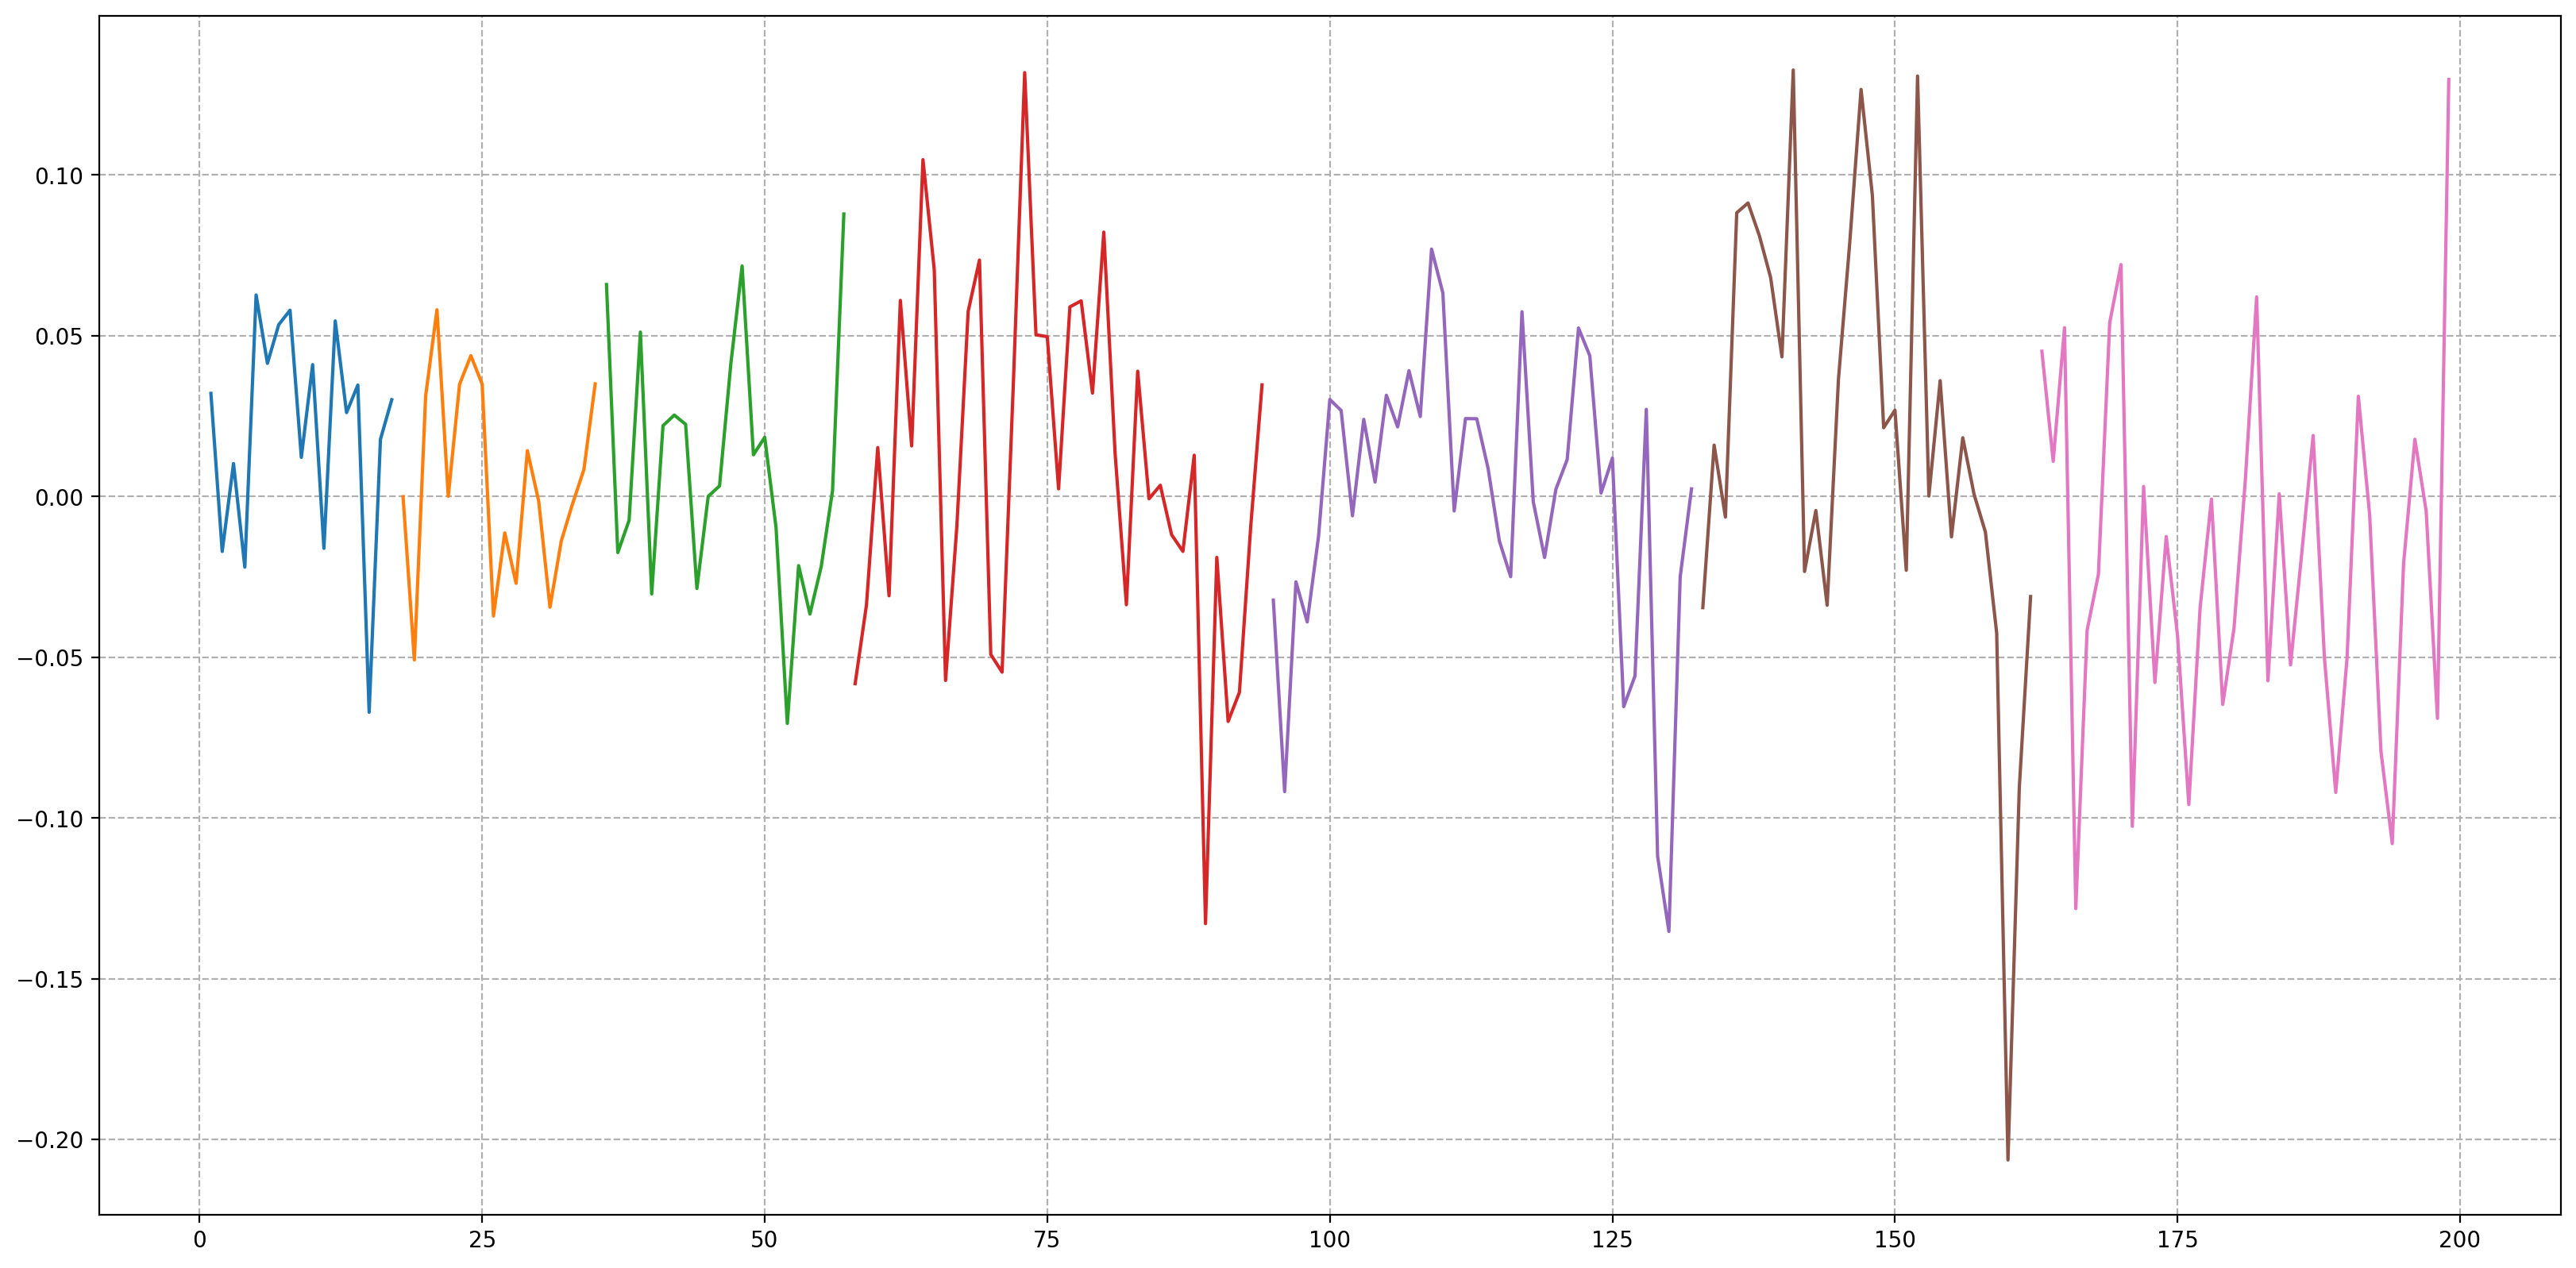

In [65]:
fig, ax = plt.subplots(figsize = (20,10), dpi = 200)
for i in range(7):
    chapters = chapter_info.loc[chapter_info["Book"] == i+1, "Global Chapter"]
    S = chapter_info.loc[chapter_info["Book"] == i+1, "Sentiment"]
    ax.plot(chapters,S)
ax.grid(linestyle = '--')

In [62]:
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
with open('data/books_in_chapters.pkl', 'rb') as file:
    books_in_chapters = pkl.load(file)

sentiment = []
for book in books_in_chapters:
    # sentiment.extend([vader_sentiment(re.split('(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s' , re.sub('\n', '', re.sub('Mrs.', 'Mrs', chapter)))) for chapter in book])
    sentiment.extend([happiness([word.lower() for word in word_tokenize(chapter) if word.isalpha()]) for chapter in book])



